In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images320x480.zip'

### Dependencies

In [0]:
from utillity_script_cloud_segmentation import *
from utillity_script_lr_schedulers2 import *

In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
model_base_path = base_path + 'Models/files/classification/'
train_path = data_path + 'train.csv'
hold_out_set_path = data_path + 'hold-out.csv'
train_images_dest_path = 'train_images/'

### Load data

In [22]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_set_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
for label in label_columns:
  X_train[label].replace({0: 1, 1: 0}, inplace=True)
  X_val[label].replace({0: 1, 1: 0}, inplace=True)

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,1f3d231.jpg,NaN,1625401 196 1625598 4 1625607 1 1625612 5 1625...,NaN,NaN,1,0,1,1,train
1,0fa3287.jpg,NaN,121884 511 123284 511 124684 511 126084 511 12...,NaN,32739 369 34139 369 35539 369 36939 369 38339 ...,1,0,1,0,train
2,4d17338.jpg,64 1141 1464 1141 2864 1141 4264 1141 5664 114...,NaN,NaN,13141 707 14541 707 15941 707 17341 707 18741 ...,0,1,1,0,train
3,12e55a8.jpg,NaN,1187509 1060 1188909 1060 1190309 1060 1191709...,NaN,2808 614 4208 614 5608 614 7008 614 8408 614 9...,1,0,1,0,train
4,697eb53.jpg,52180 1006 53580 1006 54980 1006 56380 1006 57...,NaN,NaN,NaN,0,1,1,1,train


# Model parameters

In [0]:
BATCH_SIZE = 64
WARMUP_EPOCHS = 3
WARMUP_LEARNING_RATE = 1e-3
EPOCHS = 30
BASE_LEARNING_RATE = 10**(-5.6)
LEARNING_RATE = 10**(-1.7)
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 10
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE
CYCLE_SIZE = 6
STEP_SIZE = (CYCLE_SIZE // 2) * STEP_SIZE_TRAIN

model_name = '24-ResNet50_%sx%s' % (HEIGHT, WIDTH)
model_path = model_base_path + '%s.h5' % (model_name)

### Data generator

In [68]:
datagen=ImageDataGenerator(rescale=1./255.,
                           vertical_flip=True,
                           horizontal_flip=True,
                           zoom_range=[1, 1.1],
                           shear_range=45.0,
                           rotation_range=360,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           brightness_range=(0.9, 1),
                           fill_mode='constant',
                           cval=0.)

test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                        dataframe=X_train,
                        directory=train_images_dest_path,
                        x_col="image",
                        y_col=label_columns,
                        target_size=(HEIGHT, WIDTH),
                        batch_size=BATCH_SIZE,
                        class_mode="other",
                        shuffle=True,
                        seed=seed)

valid_generator=test_datagen.flow_from_dataframe(
                             dataframe=X_val,
                             directory=train_images_dest_path,
                             x_col="image",
                             y_col=label_columns,
                             target_size=(HEIGHT, WIDTH),
                             batch_size=BATCH_SIZE,
                             class_mode="other",
                             shuffle=True,
                             seed=seed)

Found 4420 validated image filenames.
Found 1105 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:656: DeprecationWarning: `class_mode` "other" is deprecated, please use `class_mode` "raw".
  '`class_mode` "raw".', DeprecationWarning)


# Model

In [0]:
def create_model(input_shape, N_CLASSES):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=input_tensor, 
                                       pooling='avg')

    x = base_model.output
    final_output = Dense(N_CLASSES, activation='sigmoid')(x)
    model = Model(input_tensor, final_output)
    
    return model

## Warmup top layers

In [0]:
model = create_model((None, None, CHANNELS), N_CLASSES)
metric_list = ['accuracy']

for layer in model.layers[:-1]:
  layer.trainable = False

optimizer = optimizers.SGD(lr=WARMUP_LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metric_list)

In [71]:
warmup_history = model.fit_generator(generator=train_generator,
                                      steps_per_epoch=STEP_SIZE_TRAIN,
                                      validation_data=valid_generator,
                                      validation_steps=STEP_SIZE_VALID,
                                      epochs=WARMUP_EPOCHS,
                                      verbose=1).history

Epoch 1/3
69/69 [==============================] - 68s 982ms/step - loss: 0.6957 - acc: 0.5590 - val_loss: 0.7344 - val_acc: 0.5335
Epoch 2/3
69/69 [==============================] - 58s 845ms/step - loss: 0.6589 - acc: 0.6038 - val_loss: 0.7327 - val_acc: 0.5346
Epoch 3/3
69/69 [==============================] - 58s 838ms/step - loss: 0.6388 - acc: 0.6305 - val_loss: 0.7307 - val_acc: 0.5375


In [0]:
for layer in model.layers:
    layer.trainable = True
    
warm_weights = model.get_weights()

# Learning rate finder

Epoch 1/1
69/69 [==============================] - 67s 971ms/step - loss: 0.7194


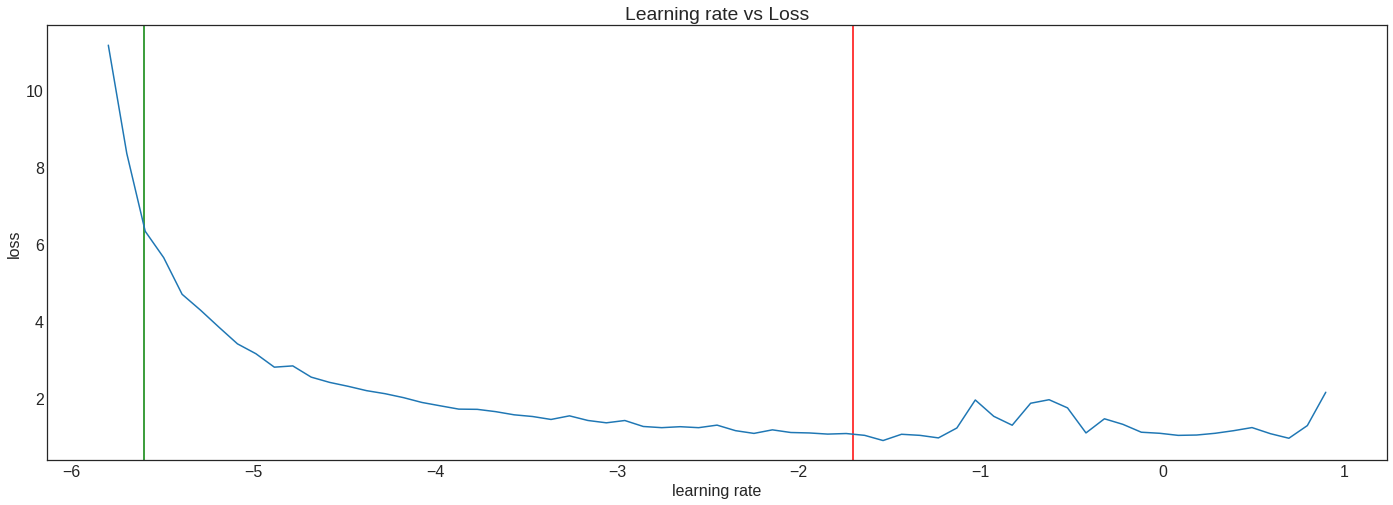

In [73]:
#@title
# #@title
lr_finder = LRFinder(num_samples=len(X_train), batch_size=BATCH_SIZE, minimum_lr=1e-6, maximum_lr=10, verbose=0)

optimizer = optimizers.SGD(lr=WARMUP_LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=STEP_SIZE_TRAIN, 
                              epochs=1, 
                              callbacks=[lr_finder])

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(24, 8))
plt.axvline(x=np.log10(BASE_LEARNING_RATE), color='green')
plt.axvline(x=np.log10(LEARNING_RATE), color='red')
lr_finder.plot_schedule(clip_beginning=2)

## Fine-tune all layers

In [0]:
model.set_weights(warm_weights)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
cyclicalLR = CyclicLR(base_lr=BASE_LEARNING_RATE, max_lr=LEARNING_RATE, step_size=STEP_SIZE, mode='triangular')

callback_list = [checkpoint, es, cyclicalLR]

optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metric_list)

In [75]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.208874). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 74s - loss: 0.5979 - acc: 0.6736 - val_loss: 0.6798 - val_acc: 0.5710
Epoch 2/30
 - 66s - loss: 0.5650 - acc: 0.7027 - val_loss: 0.6476 - val_acc: 0.6054
Epoch 3/30
 - 66s - loss: 0.5589 - acc: 0.7076 - val_loss: 0.5945 - val_acc: 0.6804
Epoch 4/30
 - 66s - loss: 0.5369 - acc: 0.7235 - val_loss: 0.7160 - val_acc: 0.6551
Epoch 5/30
 - 65s - loss: 0.5171 - acc: 0.7387 - val_loss: 0.7088 - val_acc: 0.6772
Epoch 6/30
 - 64s - loss: 0.5090 - acc: 0.7433 - val_loss: 0.7303 - val_acc: 0.6662
Epoch 7/30
 - 64s - loss: 0.4993 - acc: 0.7488 - val_loss: 0.6908 - val_acc: 0.6801
Epoch 8/30
 - 64s - loss: 0.5067 - acc: 0.7476 - val_loss: 0.8214 - val_acc: 0.6424
Epoch 9/30
 - 64s - loss: 0.5123 - acc: 0.7409 - val_loss: 0.6650 - val_acc: 0.6527
Epoch 10/30
 - 65s - loss: 0.5052 - acc: 0.7455 - val_loss: 0.6224 - val_acc: 0.7020
Epoch 11/30
 - 63s - loss: 0.5004 - acc: 0.7467 - val_loss: 0.7513 - val_acc: 0.6645
Epoch 12/30
 - 64s - loss: 0.4880 - acc: 0.7600 - val_loss: 0.7497 - val_acc: 0.6688


## Model loss graph

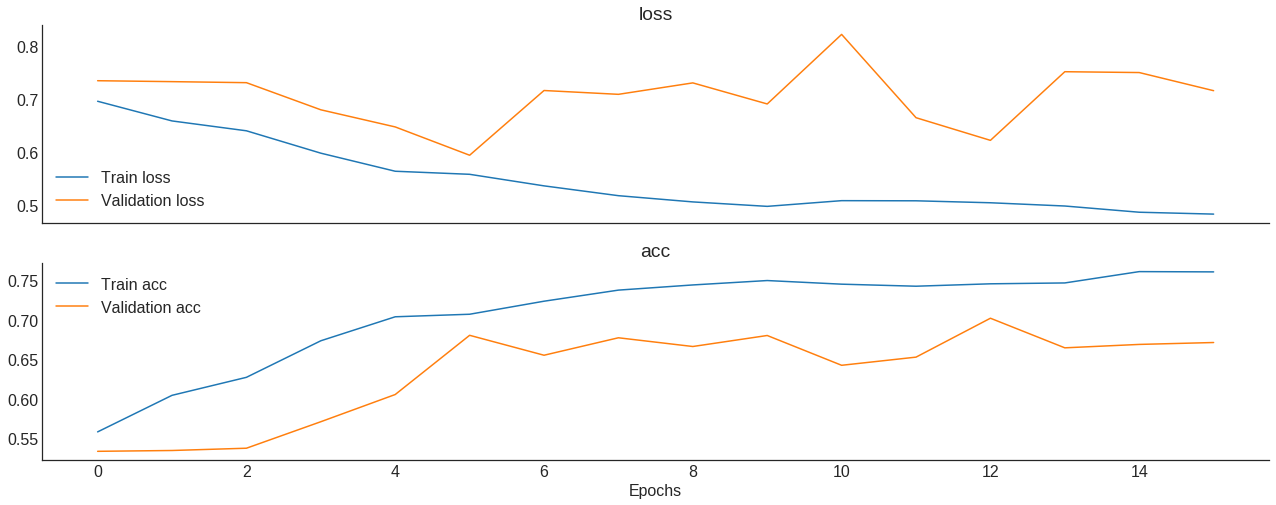

In [76]:
#@title
metrics_history = ['loss', 'acc']
for metric_hist in metrics_history:
  history[metric_hist] = warmup_history[metric_hist] + history[metric_hist]
  history['val_' + metric_hist] = warmup_history['val_' + metric_hist] + history['val_' + metric_hist]

plot_metrics(history, metric_list=metrics_history)

## Scheduler learning rates

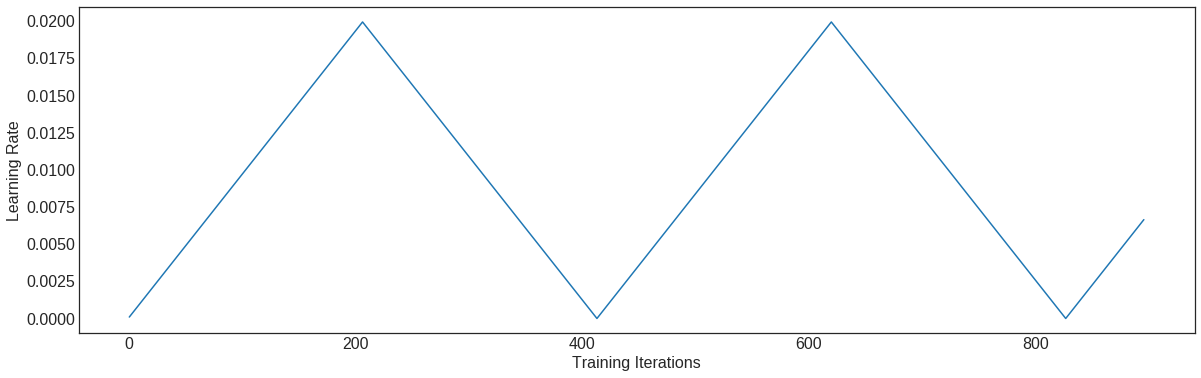

In [77]:
#@title
fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))

plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.plot(cyclicalLR.history['lr'])
plt.show()